In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

from matplotlib.lines import Line2D

import seaborn as sns
import os

def close_plot():
    plt.cla()
    plt.clf()
    plt.close()

def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels, **kwargs):
            self.set_thetagrids(np.degrees(theta), labels, **kwargs)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


In [2]:
import pandas as pd
results = pd.read_csv('data/Kang/results.csv', index_col=0)
rename_dict = {'No Integration': "No Int.",
               'scanorama': 'Scanorama',
               'scanorama + ICAT': 'Scanorama + ICAT'}
results.rename(index=rename_dict, inplace=True)

In [3]:
# plt.style.use('../src/configs/figures.mplstyle')
def radar_plot(data, feature, color='blue', frame='polygon', fill=True, ax = None):
    theta = radar_factory(data.shape[0], frame=frame)
    spoke_labels = np.array(data.index.values)
    if ax is None:
        fig, ax = plt.subplots(subplot_kw=dict(projection='radar'))
        ax.set_rgrids(np.arange(0, 1.2, 0.2))
        ax.set_title(feature, weight='bold', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        ax.set_ylim(0, 1) 

    ax.plot(theta, data[feature], color=color, label=feature, lw=3)
    if fill:
        ax.fill(theta, data[feature],  color=color, facecolor=color, alpha=0.25)
    for i, each in enumerate(spoke_labels):
        if 3.14 / 2 < theta[i] < 3.14 * 3 / 2:
            spoke_labels[i] = "\n" + each
    ax.set_varlabels(spoke_labels, horizontalalignment='center')
    return ax, theta

METHOD_ORDER = ['ICAT', 'No Int.',  
                'Seurat 3.1', 'Seurat 3.1 + ICAT',
                'Scanorama', 'Scanorama + ICAT']

def get_method_order(data):
    return data.loc[METHOD_ORDER, :]


figdir = os.path.join('figures', 'spiderplots')
if not os.path.exists(figdir):
    os.makedirs(figdir)

In [4]:

colors = {'ICAT': '#d62728',
          'No Int.': '#A846A0',
          'Seurat 3.1': '#61D190',#'#8DCC78',
          'Seurat 3.1 + ICAT': '#0f783e',#, '#13754E',
          'Scanorama': '#72A1E5',
          'Scanorama + ICAT': '#273f87'}

results = results.loc[colors.keys(), :].rename(columns={'davies': 'DB'})
results = get_method_order(results)
metrics = ['ARI', 'LISI', 'DB']

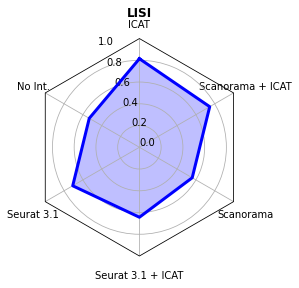

In [5]:
# necessary to plot one otherwise radar projection doesn't take
ax, __ = radar_plot(results, 'LISI')
# help(ax.set_varlabels)
plt.show()
close_plot()

In [6]:
bench = pd.read_csv('data/Tian/results.csv', index_col=0)
bench.rename(index=rename_dict, inplace=True)
bench = get_method_order(bench)
bench[metrics]

,ARI,LISI,DB
ICAT,0.646761,0.295381,0.793461
No Int.,0.463454,0.210800,0.000000
Seurat 3.1,0.692705,0.274683,0.416539
Seurat 3.1 + ICAT,0.667675,0.317848,0.827092
Scanorama,0.651517,0.168385,0.221641
Scanorama + ICAT,0.813690,0.366479,1.000000


In [7]:
# sns.set_style(style="whitegrid")

import itertools
from matplotlib import patches
def flip(items, ncol):
    """
    Flips matplotlib legends to increment by rows before columns.

    Taken from here:
    https://stackoverflow.com/questions/10101141/matplotlib-legend-add-items-across-columns-instead-of-down
    """
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])


def lollipop_plot(data, metrics, colors=colors, legend='bottom', ax=None,
                  s=13,
                  metric_order=['ARI', 'LISI', 'DB'],
                  strip_kwargs=dict()):
    subset = data[metrics].copy()
    subset['Method'] = subset.index.values
    plotdata = subset.melt(id_vars='Method', var_name='Metric', value_name='Score')
    plotdata['Metric'] = pd.Categorical(plotdata['Metric'],
                                        [x for x in metric_order if x in metrics])
#                                         ['ARI', 'AMI', 'FM', 'LISI', 'Sil.', 'DB'])
    plotdata['Method'] = pd.Categorical(plotdata['Method'], METHOD_ORDER)
    xmins = plotdata.groupby('Metric')['Score'].min()
    xmaxs = plotdata.groupby('Metric')['Score'].max()
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 7))
    ax.hlines(y=range(xmins.shape[0]), xmin=xmins,
              xmax=xmaxs, color='grey', alpha=1)
    ax = sns.stripplot(data=plotdata.sort_values('Metric'),
                       y='Metric', x='Score', hue='Method',orient='h', s=s,
                       edgecolor='black',
                       alpha=0.85, jitter=False, palette=colors, ax=ax,
                       **strip_kwargs)
    xmin = round(plotdata['Score'].min(), 1)
    xmax = round(plotdata['Score'].max(), 1)
    if int(xmin) == xmin:
        xmin = int(xmin)
    if int(xmax) == xmax:
        xmax = int(xmax)
    ax.set_xticks([xmin, xmax])
#     dx = (xmax - xmin) * 0.1
#     ax.set_xlim([xmin - dx, xmax + dx])
    
    ax.grid(False, axis='y')
    ax.grid(False, axis='x')
    if legend == 'bottom':
        handles, labels = ax.get_legend_handles_labels()
        shifted_h = []
        shifted_l = []
        for i, (h, l) in enumerate(zip(handles, labels)):
            if i == 3:
                shifted_h.append(patches.Rectangle((0,0), 1, 1, fill=False, edgecolor='none',
                                  visible=False))
                shifted_l.append('')
            shifted_h.append(h)
            shifted_l.append(l)
        ax.legend(flip(shifted_h, 4), flip(shifted_l, 4),
                  loc='upper left', bbox_to_anchor=(-0.06, -0.1), markerscale=2, fontsize='medium',
                  ncol=4, labelspacing=0, columnspacing=0, handletextpad=0)
    elif legend == 'right':
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels,
                  loc='upper right', bbox_to_anchor=(1.1, 1),
                  markerscale=1.5, fontsize=18,
                  ncol=1, labelspacing=0, columnspacing=0, handletextpad=0)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
#     plt.tight_layout()
    return ax

In [8]:
kago = pd.read_csv('data/Kagohara/results.csv', index_col=0)
kago.rename(index=rename_dict, inplace=True)

In [9]:
kago = get_method_order(kago)

[0.        2.0943951 4.1887902]


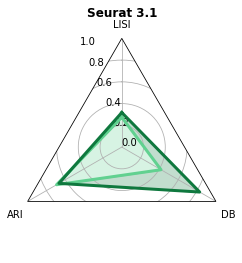

In [10]:
# radar_plot(kago.query('index==ICAT'))
ax, theta1 = radar_plot(bench[['LISI', 'ARI', 'DB']].T, 'Seurat 3.1',
                       fill=True,
                       color=colors['Seurat 3.1'])
ax, theta2 = radar_plot(bench[['LISI', 'ARI', 'DB']].T, 'Seurat 3.1 + ICAT',
                fill=False,
                color=colors['Seurat 3.1 + ICAT'], ax=ax)
print(theta2)
ax.fill_between(np.hstack([theta2, [theta2[0]]]),
                bench.loc['Seurat 3.1 + ICAT', ['LISI', 'ARI', 'DB', 'LISI']].T,
                bench.loc['Seurat 3.1', ['LISI', 'ARI', 'DB', 'LISI']].T,
                color=colors['Seurat 3.1 + ICAT'], alpha=0.25)
plt.show()
close_plot()

In [11]:
# combined plot
def format_method(name):
    if '+' in name:
        return name.replace(' +', '\n+')
    if name == 'No Integration':
        return 'No Int.'
    return name


colors = {'ICAT': '#d62728',
          'NCFS + Louvain': '#F3752B',
          'No Int.': '#A846A0',
          'Seurat 3.1': '#61D190',#'#8DCC78',
          'Seurat 3.1 + ICAT': '#13754E',
          'Scanorama': '#72A1E5',
          'Scanorama + ICAT': '#273f87'}

subfig_dict = {'Kagohara': 'A2','Kang': 'A3', 'Tian': 'A1'}

# figure set up
def spiderplot(methods, metrics, figsize=(9, 12)):
    with sns.plotting_context("paper", font_scale=1, rc=rc):
        fig, axes = plt.subplots(nrows=len(methods), ncols=3,
                                 figsize=figsize,
                                 dpi=200,
                                 subplot_kw=dict(projection='radar'),
                                 constrained_layout=False)

        for data, name, j in zip([bench, kago, results], ['Tian', 'Kagohara', 'Kang'], [0, 1, 2]):
            # plot spider plots
            view = data[data.index.isin(methods)].copy()
            for i, method in enumerate(view.index):
                print(method, name)
                ax = axes[i, j]
                if i == 0:
                    dy = 1
                    dx = 0.0
                    if len(name) > 4:
                        dx = 0.0
    #                 ax.annotate(subfig_dict[name], (dx, dy),
    #                             xycoords='axes fraction', fontsize=36)
                    ax.set_title(name, position=(0.5, 1.2),
                                 fontsize=12,
                                 fontweight='bold')
                ax.set_rgrids(np.arange(0, 1, 0.25), fontsize=10, angle=360/10)
                ax.set_ylim(0, 1)
                radar_plot(view[metrics].T, method, color=colors[method], frame='polygon', ax=ax)
                ax.set_yticklabels([])
                ax.set_xticklabels(ax.get_xticklabels())#, fontsize=18)
                ax.tick_params(axis='both', which='both', pad=0)
                if j == 0:
                    ax.set_ylabel(format_method(method),
                                  fontsize=12,
                                  fontweight='bold',
                                  rotation=0,
                                  labelpad=50,
                                  verticalalignment='center')

        return fig

def lolli_fig(methods, metrics, lollipop_order=None, figsize=(3, 8),
              fig_anno='B', **kwargs):
    with sns.plotting_context("paper", font_scale=1, rc=rc):
        fig, axes = plt.subplots(nrows=3, ncols=1,
                                 figsize=figsize, dpi=200)
#         fig, axes = plt.subplots(nrows=2, ncols=2,
#                                  figsize=figsize, dpi=200)

        for data, name, lax in zip([bench, kago, results],
                                  ['Tian', 'Kagohara', 'Kang'],
                                  axes.flatten()):
            # plot spider plots
            view = data[data.index.isin(methods)].copy()
            if lollipop_order is None:
                lollipop_order = view.index.values
            lax = lollipop_plot(view.loc[lollipop_order, :],
                                metrics, colors=colors, legend='right', ax=lax,
                                strip_kwargs=dict(hue_order=lollipop_order),
                                **kwargs)
#             lax.annotate(subfig_dict[name].replace('A', fig_anno),
#                          (0.8, 0.95), xycoords='axes fraction', fontsize=36)
            lax.set_title(name, loc='left', fontweight='bold', fontsize=12)
            lax.set_ylabel('')
            lax.set_xlabel('')
            lax.legend_.remove()
#             if name != 'Tian':# or any(['+ ICAT' in x for x in methods]):
#                 lax.legend_.remove()
#             else:
#                 handles, labels = lax.get_legend_handles_labels()
#                 lorder = []
#                 for l in labels:
#                     idx = np.where(view.index.values == l)[0][0]
#                     lorder.append(idx)
#                     if '+ ICAT' in l:
#                         bbox_shift = -0.2
#                         do_flip = False
#                 lax.legend_.remove()
#                 shifted_h = np.array(handles)[lorder]
#                 shifted_l = np.array([format_method(x) for x in labels])[lorder]
#                 bbox_shift = -0.15
#                 do_flip = True
#                 if do_flip:
#                     shifted_h = flip(shifted_h, 2)
#                     shifted_l = flip(shifted_l, 2)
#                 legend_ax = axes.flatten()[-1]
#                 legend_ax.legend(shifted_h, shifted_l,
#                                  loc='upper left',
#                                  bbox_to_anchor=(-.25, 1),
#                                  markerscale=1,
# #                                  fontsize=18,
#                                  ncol=1, labelspacing=0, columnspacing=0, handletextpad=0)
#                 legend_ax.axis('off')
        fig.subplots_adjust(hspace=0.5, wspace=0.5)
        return fig, axes


In [12]:
results

,AMI,ARI,calinksi.known,CH,Comp.,DB,davies.known,FM,Homog.,sil.known,Sil.,LISI,Cluster Performance
ICAT,0.707550,0.714532,4953.051851,0.196678,0.709735,1.000000,2.478426,0.784951,0.705688,0.231982,0.290187,0.814578,0.735678
No Int.,0.574447,0.322588,2717.069099,0.000000,0.469283,0.000000,2.799876,0.471825,0.741919,0.117630,0.131078,0.532727,0.456287
Seurat 3.1,0.693776,0.577501,4689.153008,0.025494,0.618846,0.112097,2.310465,0.679644,0.790098,0.159627,0.136937,0.708260,0.650307
Seurat 3.1 + ICAT,0.639756,0.505425,4530.890294,0.084158,0.587953,0.305260,2.409658,0.618853,0.702128,0.199309,0.137653,0.643563,0.588011
Scanorama,0.645485,0.497001,3242.469920,0.048960,0.588365,0.483225,2.580955,0.612414,0.715519,0.125352,0.179768,0.560704,0.584967
Scanorama + ICAT,0.591166,0.565890,17757.184014,1.000000,0.554075,0.646917,2.878015,0.667594,0.634278,0.185082,0.192861,0.746577,0.608217


ICAT Tian
No Int. Tian
Seurat 3.1 Tian
Scanorama Tian
ICAT Kagohara
No Int. Kagohara
Seurat 3.1 Kagohara
Scanorama Kagohara
ICAT Kang
No Int. Kang
Seurat 3.1 Kang
Scanorama Kang


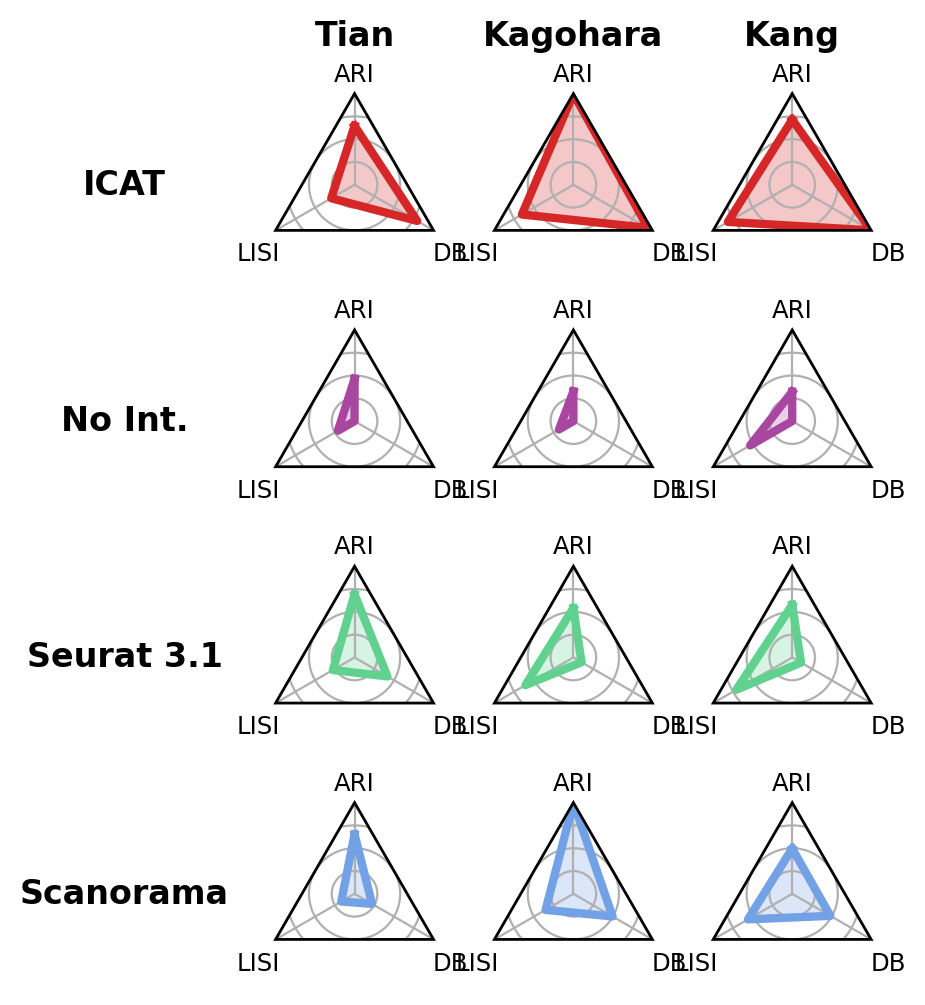

In [13]:

rc = {"xtick.major.pad": 0,
      "ytick.major.pad": 0,
      "xtick.major.size": 0,
      "xtick.minor.size": 0,
      "ytick.major.size": 0,
      "ytick.minor.size": 0,
      "lines.linewidth": 2,
      "figure.subplot.left": 0.08,
      "figure.subplot.right": 0.95,
      "figure.subplot.bottom": 0.07,
      "figure.subplot.wspace": 0.25,
      "figure.subplot.hspace": 0.25,
      "legend.labelspacing": 0,
      "legend.handletextpad": 0,
      "legend.columnspacing": 0,
      "font.family": "sans-serrif"}

with sns.plotting_context("paper", font_scale=1, rc=rc):
    spiderplot(['ICAT', 'No Int.', 'Seurat 3.1', 'Scanorama'], metrics,
               figsize=(4, 6))
# this saves better than it looks in jupyter lab
plt.savefig(os.path.join(figdir, 'main_methods_spiderplot.svg'),
            bbox_inches='tight', dpi=200)
plt.show()
close_plot()

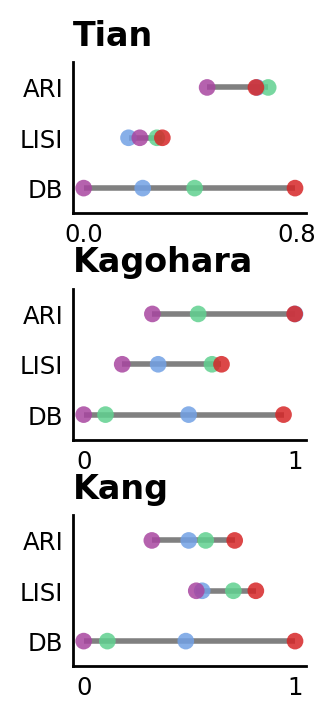

In [14]:
lolli_fig(['ICAT', 'No Int.', 'Seurat 3.1', 'Scanorama'],
          metrics,
          lollipop_order=['ICAT', 'No Int.', 'Seurat 3.1', 'Scanorama'][::-1],
          figsize=(1.5, 4),
          s=6)
plt.savefig(os.path.join(figdir, 'main_methods_lolli.svg'),
            bbox_inches='tight')

In [15]:
def spiderplot_embedded(methods, metrics, transpose=False, figsize=(9, 6)):        
#     fig = plt.figure(figsize=(14 - 3.5, 3 * 3),
#                      constrained_layout=False)
    with sns.plotting_context("paper", font_scale=1, rc=rc):
        if transpose:
            fig, axes = plt.subplots(nrows=2, ncols=3,
                             figsize=figsize,
                             subplot_kw=dict(projection='radar'),
                             dpi=200,
                             constrained_layout=False)
        else:
            fig, axes = plt.subplots(nrows=3, ncols=2,
                                     figsize=figsize,
                                     subplot_kw=dict(projection='radar'),
                                     dpi=200,
                                     constrained_layout=False)
        method_to_pos = {'Seurat 3.1': 0,
                         'Seurat 3.1 + ICAT': 0,
                         'Scanorama': 1,
                         'Scanorama + ICAT': 1}

        for data, name, i in zip([bench, kago, results], ['Tian', 'Kagohara', 'Kang'], [0, 1, 2]):
            # plot spider plots
            view = data[data.index.isin(methods)].copy()
            for m_i, method in enumerate(view.index):
                if '+ ICAT' in method:
                    continue
                if transpose:
                    ax = axes[method_to_pos[method], i]
                else:
                    ax = axes[i, method_to_pos[method]]
                if i == 0:
                    dy = 1
                    dx = 0.0
                    label = f"A{method_to_pos[method] + 1}"
                    if transpose:
                        dx = -0.1
                        label = f"C{method_to_pos[method] + 1}"
#                     ax.annotate(label, (dx, dy),
#                                 xycoords='axes fraction',
#                                 fontsize=36,
#                                )
                if (i == 2 and not transpose) or (i == 0 and transpose):
                    abrev = 'Seurat'
                    if method == 'Scanorama':
                        abrev = 'Scan'
                    
                    labels = [method, 'ICAT$_{' + abrev + '}$']
                    custom_lines = [Line2D([0], [0], color=colors[x], lw=3)\
                                    for x in [method, method + ' + ICAT']]
                    if transpose:
                        bbox = (-1, 1)
                        loc='upper left'
                    else:
                        bbox = (-0.3, -0.2)
                        loc='lower left'
#                     ax.legend(custom_lines, labels,
#                               loc=loc,
#                               bbox_to_anchor=bbox)
#     #                 ax.set_title(titles[method_to_row[method]],
    #                              position=(0.5, 1.1))

                ax, theta = radar_plot(view[metrics].T, method, color=colors[method],
                                       frame='polygon', ax=ax)
                ax.set_rgrids(np.arange(0, 1, 0.25),
#                               fontsize=16,
                              angle=360/10)
                ax.set_ylim(0, 1)
                if method in ['Seurat 3.1', 'Scanorama']:
                    extended = method + ' + ICAT'
                    ax, theta = radar_plot(view[metrics].T, extended,
                                           fill=False,
                                           color=colors[extended],
                                           frame='polygon',
                                           ax=ax)
                    loop = metrics + [metrics[0]]
                    ax.fill_between(np.hstack([theta, [theta[0]]]),
                                    view.loc[extended, loop].T,
                                    view.loc[method, loop].T,
                                    color=colors[extended], alpha=0.25)

                ax.set_yticklabels([])
                ax.set_xticklabels(ax.get_xticklabels(),
#                                    fontsize=18,
                                  )
                if m_i == 0 and not transpose:
                    ax.set_ylabel(name, rotation=0,
                                  labelpad=75,
                                  verticalalignment='center')
                elif m_i == 0 and transpose:
                    ax.set_title(name,
                                 position=(0.5, 1.2),
                                 fontsize=12,
                                 fontweight='bold')
        fig.subplots_adjust(hspace=0.01)

#     fig.subplots_adjust(hspace=0.01, wspace=0.25)
    return fig, axes

In [16]:
kago.index.values

array(['ICAT', 'No Int.', 'Seurat 3.1', 'Seurat 3.1 + ICAT', 'Scanorama',
       'Scanorama + ICAT'], dtype=object)

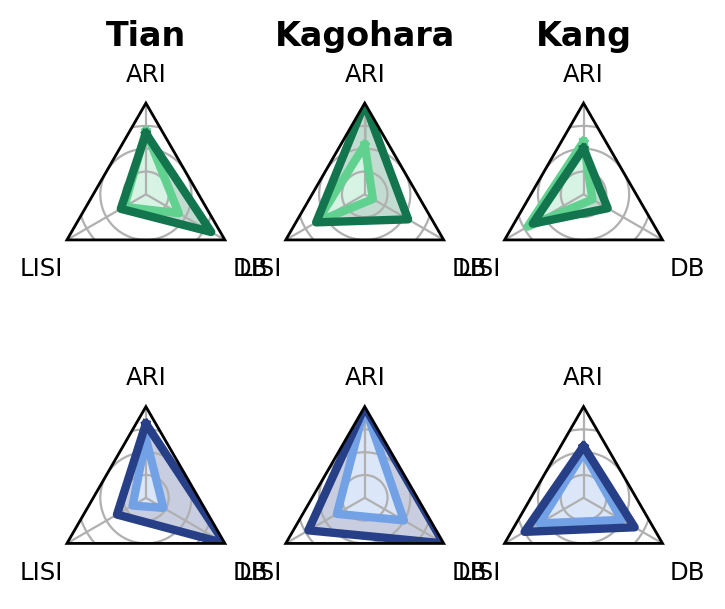

In [17]:
fig, axes = spiderplot_embedded(['Seurat 3.1', 'Seurat 3.1 + ICAT',
                                 'Scanorama', 'Scanorama + ICAT'],
                                 metrics, True, figsize=(4, 4))
plt.savefig(os.path.join(figdir, 'extended_embedded.svg'),
            bbox_inches='tight')

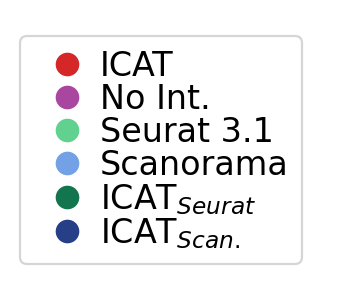

In [18]:
#                     custom_lines = [Line2D([0], [0], color=colors[x], lw=3)\
#                                     for x in [method, method + ' + ICAT']]
methods = ['ICAT', 'No Int.', 'Seurat 3.1', 'Scanorama', 'Seurat 3.1 + ICAT', 'Scanorama + ICAT']
labels = ['ICAT', 'No Int.', 'Seurat 3.1', 'Scanorama', 'ICAT$_{Seurat}$', 'ICAT$_{Scan.}$']
#       "legend.labelspacing": 0,
#       "legend.handletextpad": 0,
#       "legend.columnspacing": 0,
custom_lines = [Line2D([0], [0], marker='o', color=colors[x],
                       lw=0)\
                for x in methods]
with sns.plotting_context("paper", font_scale=1, rc=rc):
    fig, ax = plt.subplots(dpi=200, figsize=(1,1))
    ax.legend(custom_lines, labels, labelspacing=0, handletextpad=0, fontsize=12,
              markerscale=1.25)
    ax.axis('off')
    plt.savefig(os.path.join(figdir, 'method_legend.svg'),
                bbox_inches='tight')
    plt.show()

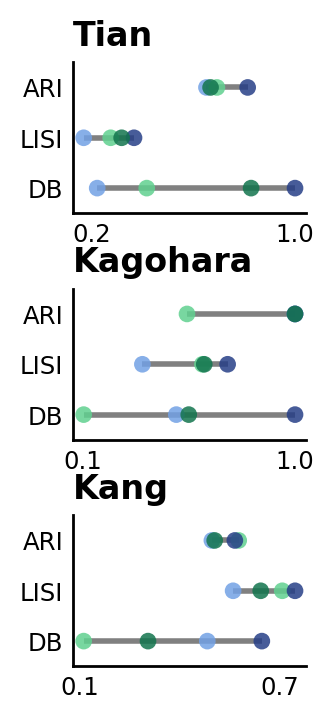

In [19]:
lolli_fig(['Seurat 3.1', 'Seurat 3.1 + ICAT', 'Scanorama', 'Scanorama + ICAT'],
          metrics,
          ['Seurat 3.1 + ICAT', 'Scanorama + ICAT', 'Seurat 3.1', 'Scanorama'][::-1],
          figsize=(1.5, 4),
          s=6)
plt.savefig(os.path.join(figdir, 'extended_lolli.svg'),
            bbox_inches='tight')

In [20]:
# results['Dataset'] = 'Kang'
# bench['Dataset'] = 'Tian'
# kago['Dataset'] = 'Kagohara'
!pip install openpyxl

In [21]:
comb = pd.concat([bench, kago, results])[['Dataset', 'ARI', 'LISI', 'DB']]
comb = comb.reset_index().rename(columns={'index': 'Method'})
comb[['Dataset', 'Method', 'ARI', 'LISI', 'DB']].set_index(['Dataset', 'Method']).to_excel('real_data_res_table.xlsx')

KeyError: "['Dataset'] not in index"

In [ ]:
test = comb.groupby('Dataset').rank(axis=0, ascending=False)
test['Method'] = comb.Method
test['Dataset'] = comb.Dataset
test[['Dataset', 'Method', 'ARI', 'LISI', 'DB']].set_index(['Dataset', 'Method'])

In [ ]:
# test['MeanRank'] = test.apply(lambda x: np.mean(x), axis=0)
test['MeanRank'] = test[metrics].mean(axis=1)
# test
test['DSRank'] = test.groupby('Dataset')['MeanRank'].rank(ascending=True)
pd.pivot_table(test[['Method', 'Dataset', 'DSRank']], index='Method', columns='Dataset')
# help(pd.pivot_table)

In [ ]:
out = pd.DataFrame(test.groupby('Method').mean().mean(axis=1).rank(),
                   columns=['Rank'])
labelsize=18
fig, ax = plt.subplots(figsize=(1, 8))
axes = sns.heatmap(out.sort_values('Rank'), cmap='Purples_r', square=True)
ax.set_yticklabels([x.get_text()\
                    for x in ax.get_yticklabels()],
                    fontsize=labelsize*1, rotation=0)
ax.set_xticklabels([x.get_text()\
                    for x in ax.get_xticklabels()], fontsize=labelsize*1,
                    rotation=90)
# plt.ylim(out.shape[0], 0)
# set ylim for cbar
fig.axes[1].set_ylim(6, 1)
fig.axes[1].annotate('Worse', (-1, -0.05), xycoords='axes fraction',
                     fontsize=labelsize*1.15)
fig.axes[1].annotate('Better', (-1, 1.01), xycoords='axes fraction',
                     fontsize=labelsize*1.15)
fig.axes[1].set_yticklabels([''] * len(fig.axes[1].get_yticks()) )
plt.ylabel('')
plt.tight_layout()
plt.show()
plt.cla()
plt.clf()
plt.close()

In [ ]:
out.rank()